<a href="https://colab.research.google.com/github/EthanSeok/Neural-Network/blob/main/train/Fruit_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import matplotlib.font_manager as fm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.init



import torchvision
from torchvision import datasets, models, transforms
import torchvision.datasets as dsets

import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.model_selection import KFold

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
%cd /
from glob import glob

directory_list = [
    '/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/train/pass',
    '/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/train/check',
    '/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/train/rot',
    '/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/validation/pass',
    '/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/validation/check',
    '/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/validation/rot'
]

for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

train_img_list = glob('/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/train/pass/*jpg') + glob('/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/train/check/*jpg') + glob('/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/train/rot/*jpg')

validation_img_list = glob('/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/validation/pass/*jpg') + glob('/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/validation/check/*jpg') + glob('/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset/validation/rot/*jpg')

print(len(train_img_list + validation_img_list))

/
2040


In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/gdrive/MyDrive/Colab_Notebooks/resnet_dataset/custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transforms_val)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size= 128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(val_datasets, batch_size= 128, shuffle=True, num_workers=4)

print('size of train data set:', len(train_datasets))
print('size of test data set:', len(val_datasets))

class_names = train_datasets.classes
print('class:', class_names)

size of train data set: 1615
size of test data set: 425
class: ['check', 'pass', 'rot']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


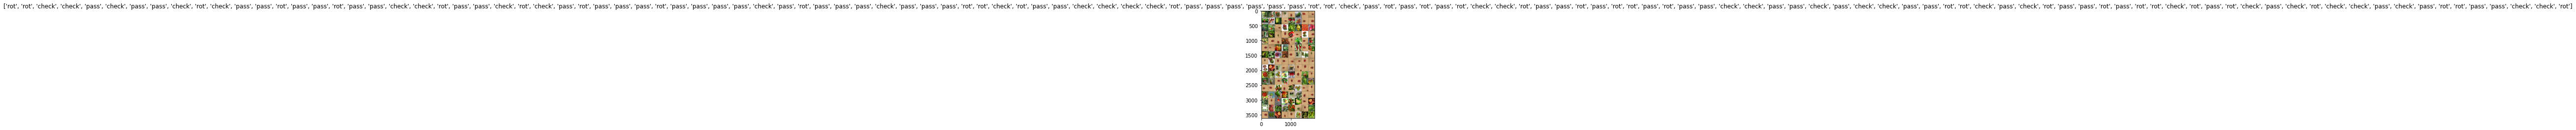

In [ ]:
def imshow(input, title):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.title(title)
    plt.show()


iterator = iter(train_loader)

inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# model = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
#             nn.BatchNorm2d(64),
 
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
#             nn.BatchNorm2d(128),
 
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
#             nn.BatchNorm2d(256),
 
#             nn.Flatten(), 
#             nn.Linear(256*4*4, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10))

In [ ]:
model = models.resnet34(pretrained=True)
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.to(device)
 
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
train_accu = []
train_losses = []

def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0
 
  for data in tqdm(train_loader):
     
    inputs,labels=data[0].to(device),data[1].to(device)
     
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
 
    running_loss += loss.item()
     
    _, predicted = outputs.max(1)
    total += labels.size(0)
    # correct += predicted.eq(labels).sum().item()
    correct += torch.sum(predicted == labels.data)
       
  train_loss=running_loss/len(train_loader)
  accu=100.*correct/total
   
  train_accu.append(accu.cpu())
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [ ]:
eval_losses=[]
eval_accu=[]
 
def test(epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for data in tqdm(test_loader):
      images,labels=data[0].to(device),data[1].to(device)
       
      outputs=model(images)
 
      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += labels.size(0)
      # correct += predicted.eq(labels).sum().item()
      correct += torch.sum(predicted == labels.data)
      
   
  test_loss=running_loss/len(test_loader)
  accu=100.*correct/total
 
  eval_losses.append(test_loss)
  eval_accu.append(accu.cpu())
 
  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))

In [ ]:
epochs=100
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 13/13 [01:18<00:00,  6.02s/it]


Train Loss: 5.252 | Accuracy: 26.873


100%|██████████| 4/4 [01:10<00:00, 17.58s/it]


Test Loss: 1.876 | Accuracy: 52.235

Epoch : 2


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Train Loss: 0.618 | Accuracy: 85.697


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


Test Loss: 1.494 | Accuracy: 61.412

Epoch : 3


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Train Loss: 0.249 | Accuracy: 93.065


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


Test Loss: 1.230 | Accuracy: 56.000

Epoch : 4


100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


Train Loss: 0.114 | Accuracy: 96.966


100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


Test Loss: 1.131 | Accuracy: 64.000

Epoch : 5


100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


Train Loss: 0.075 | Accuracy: 98.452


100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


Test Loss: 1.081 | Accuracy: 66.118

Epoch : 6


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


Train Loss: 0.044 | Accuracy: 99.381


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Test Loss: 1.024 | Accuracy: 67.294

Epoch : 7


100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


Train Loss: 0.032 | Accuracy: 99.567


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Test Loss: 1.038 | Accuracy: 66.824

Epoch : 8


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


Train Loss: 0.029 | Accuracy: 99.505


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Test Loss: 1.127 | Accuracy: 66.588

Epoch : 9


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


Train Loss: 0.024 | Accuracy: 99.628


100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


Test Loss: 1.153 | Accuracy: 66.353

Epoch : 10


100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


Train Loss: 0.018 | Accuracy: 99.752


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Test Loss: 1.116 | Accuracy: 66.118

Epoch : 11


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


Train Loss: 0.018 | Accuracy: 99.752


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Test Loss: 1.077 | Accuracy: 65.412

Epoch : 12


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


Train Loss: 0.014 | Accuracy: 99.814


100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


Test Loss: 1.234 | Accuracy: 66.118

Epoch : 13


100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


Train Loss: 0.011 | Accuracy: 99.938


100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


Test Loss: 1.094 | Accuracy: 65.882

Epoch : 14


100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


Train Loss: 0.008 | Accuracy: 99.938


100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


Test Loss: 1.070 | Accuracy: 65.647

Epoch : 15


100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


Train Loss: 0.012 | Accuracy: 99.814


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Test Loss: 1.178 | Accuracy: 65.176

Epoch : 16


100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


Train Loss: 0.008 | Accuracy: 100.000


100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


Test Loss: 1.164 | Accuracy: 65.176

Epoch : 17


100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


Train Loss: 0.007 | Accuracy: 100.000


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


Test Loss: 1.196 | Accuracy: 65.882

Epoch : 18


100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


Train Loss: 0.007 | Accuracy: 100.000


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Test Loss: 1.169 | Accuracy: 65.176

Epoch : 19


 31%|███       | 4/13 [00:04<00:10,  1.19s/it]


KeyboardInterrupt: ignored

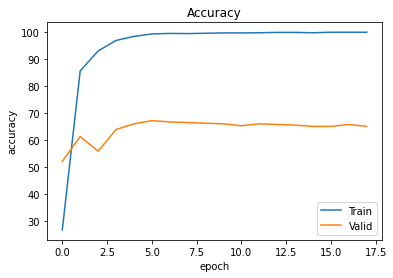

In [ ]:
plt.plot(train_accu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Accuracy')
 
plt.show()

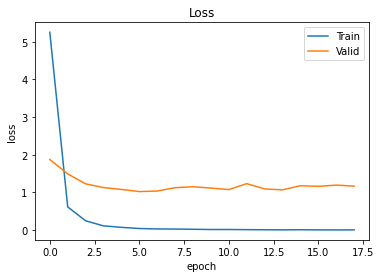

In [ ]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Loss')
 
plt.show()

In [ ]:
!wget https://plantvillage-production-new.s3.amazonaws.com/images/pics/000/001/278/original/1573722-SMPT.jpg -O test_image.jpg

--2022-08-19 17:36:59--  https://plantvillage-production-new.s3.amazonaws.com/images/pics/000/001/278/original/1573722-SMPT.jpg
Resolving plantvillage-production-new.s3.amazonaws.com (plantvillage-production-new.s3.amazonaws.com)... 52.216.32.113
Connecting to plantvillage-production-new.s3.amazonaws.com (plantvillage-production-new.s3.amazonaws.com)|52.216.32.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132914 (130K) [image/jpeg]
Saving to: ‘test_image.jpg’

test_image.jpg      100%[===================>] 129.80K   512KB/s    in 0.3s    

2022-08-19 17:37:00 (512 KB/s) - ‘test_image.jpg’ saved [132914/132914]



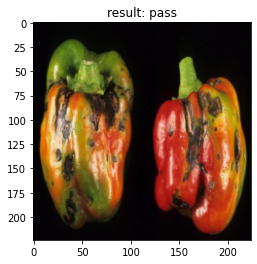

In [ ]:
from PIL import Image


image = Image.open('test_image.jpg')
image = transforms_val(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='result: ' + class_names[preds[0]])